In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2
from glob import glob
import seaborn as sns
# import random
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_curve, auc, confusion_matrix


# 1. Symptoms Dataset


Data loaded successfully.

Symptoms Dataset Details
Training Samples: 391
Test Samples: 414
Number of Classes: 391
Number of Symptoms: 1326

Sample Entries:


,Belly button that sticks out,Bulge in the groin or scrotum,Delayed sexual maturity,Delayed teeth,Downward palpebral slant to eyes,"Hairline with a ""widow's peak""",Mildly sunken chest (pectus excavatum),Mild to moderate cognitive problems,Mild to moderate short height,Poorly developed middle section of the face,...,Tiny white spots inside the mouth (Koplik spots),Abnormal strength and direction of urine stream,Bed wetting,Bleeding (hematuria) at end of urination,Visible narrowing of the urethral opening in boys,Swelling and redness of eyelid edges,Slight blurring of vision due to excess oil in tears,Frequent styes(bumps),Pressure in the ear,Prognosis
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,Aarskog syndrome
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Aase syndrome



Each row represents a unique disease: True


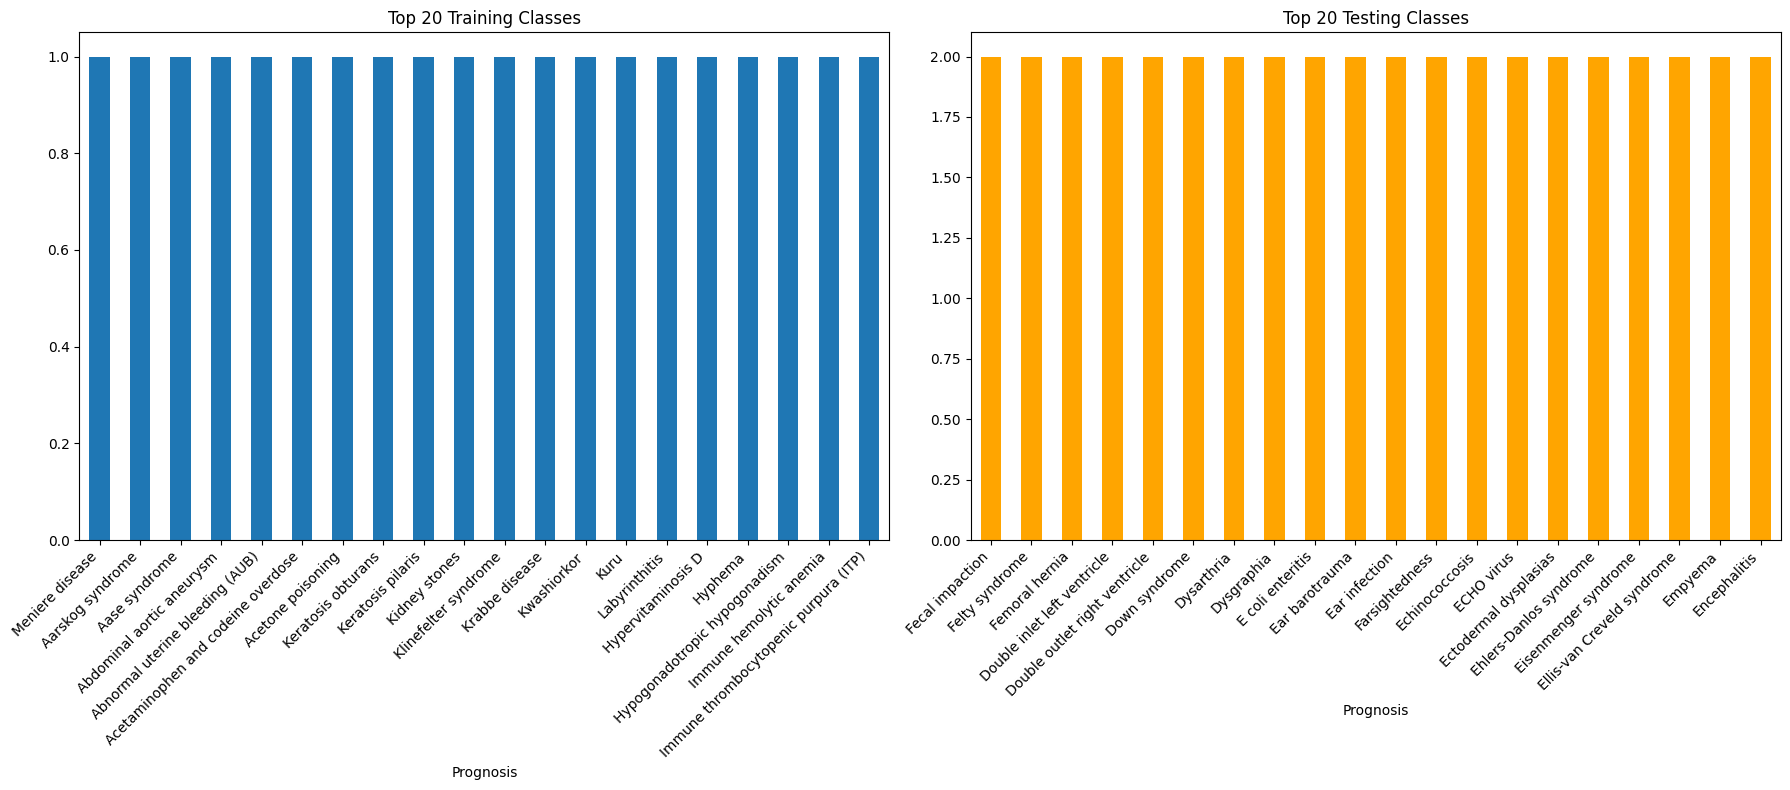


Tuberculosis Case Analysis:
Found 1 TB cases in training set

TB Symptom Annotations (13 symptoms):
1. Pain in the abdomen
2. Cough
3. Unintentional weight loss
4. Shortness of breath
5. Excessive sweating
6. Joint pain
7. fever
8. Fever-- usually low-grade
9. Swelling of abdomen
10. Malaise(general discomfortness,ill feeling or uneasiness)
11. Chills
12. Pale skin due to anemia (pallor)
13. Swollen glands


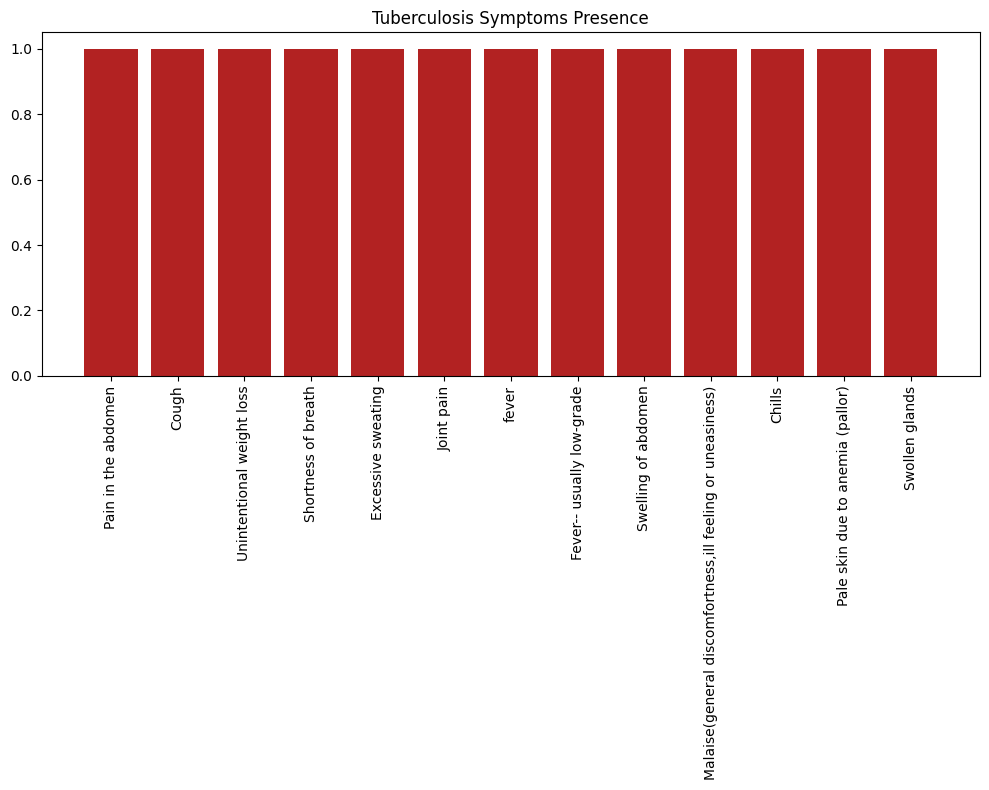


Binary Classification Dataset:
Training set: (391, 1326), Positive TB cases: 1
Testing set: (414, 1326), Positive TB cases: 1


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


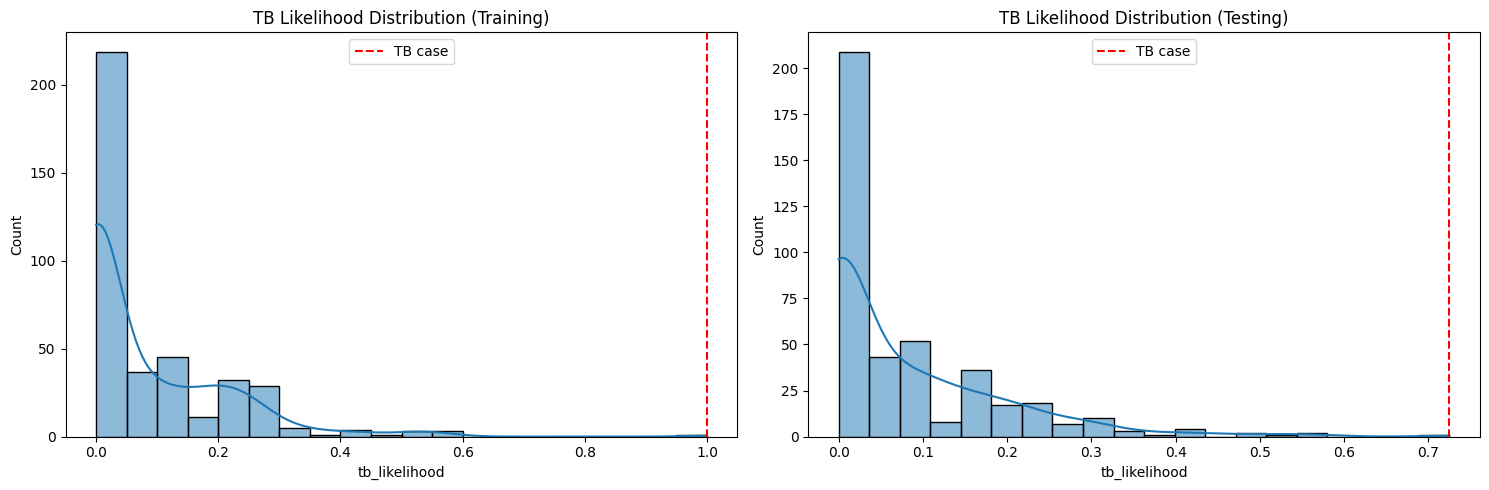


Diseases with TB-like symptoms:
                        Prognosis  tb_likelihood
88             Atypical pneumonia          0.575
337  Hypersensitivity pneumonitis          0.550
80                  Aspergillosis          0.550
48           Amebic liver abscess          0.525
168                 CMV pneumonia          0.525
230                       Empyema          0.500
86                  Atrial myxoma          0.475
122                 Bronchiolitis          0.425
59                        Anthrax          0.425
157  Chronic lymphocytic leukemia          0.425

TB-focused dataset dimensions:
Training: (391, 13)
Testing: (414, 13)

Sample TB-focused data:


,Pain in the abdomen,Cough,Unintentional weight loss,Shortness of breath,Excessive sweating,Joint pain,fever,Fever-- usually low-grade,Swelling of abdomen,"Malaise(general discomfortness,ill feeling or uneasiness)",Chills,Pale skin due to anemia (pallor),Swollen glands
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0



Dataset Summary:
- Full dataset contains 391 training and 414 test samples
- Each sample has 1326 symptom features
- TB case identified: 'Disseminated tuberculosis' with 13 characteristic symptoms
- TB likelihood scores calculated based on weighted symptom presence
- Binary classification task: Distinguishing TB from 390 other diseases


In [27]:

try:
    if os.path.exists('/kaggle/input/disease-prediction-using-symptoms/trainings.csv'):
        train_symptoms = pd.read_csv('/kaggle/input/disease-prediction-using-symptoms/trainings.csv', encoding='windows-1252')
        test_symptoms = pd.read_csv('/kaggle/input/disease-prediction-using-symptoms/testing.csv', encoding='windows-1252')
    else:
        train_symptoms = pd.read_csv('trainings.csv', encoding='windows-1252')
        test_symptoms = pd.read_csv('testing.csv', encoding='windows-1252')
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")


print("\nSymptoms Dataset Details")
print(f"Training Samples: {len(train_symptoms)}")
print(f"Test Samples: {len(test_symptoms)}")
print(f"Number of Classes: {train_symptoms['Prognosis'].nunique()}")
print(f"Number of Symptoms: {len(train_symptoms.columns[:-1])}")


print("\nSample Entries:")
display(train_symptoms.head(2))


is_one_to_one = len(train_symptoms) == train_symptoms['Prognosis'].nunique()
print(f"\nEach row represents a unique disease: {is_one_to_one}")

# Visualizing our class distribution
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
train_count = train_symptoms['Prognosis'].value_counts().head(20)
train_count.plot(kind='bar', title='Top 20 Training Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.subplot(1, 2, 2)
test_count = test_symptoms['Prognosis'].value_counts().head(20)
test_count.plot(kind='bar', title='Top 20 Testing Classes', color='orange')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('class_distribution.png', bbox_inches='tight', dpi=300)
plt.show()


print("\nTuberculosis Case Analysis:")
tb_train = train_symptoms[train_symptoms['Prognosis'] == 'Disseminated tuberculosis']
tb_test = test_symptoms[test_symptoms['Prognosis'] == 'Disseminated tuberculosis']

if len(tb_train) > 0:
    print(f"Found {len(tb_train)} TB cases in training set")

    tb_symptoms = tb_train.iloc[0, :-1][tb_train.iloc[0, :-1] == 1].index.tolist()
    print(f"\nTB Symptom Annotations ({len(tb_symptoms)} symptoms):")
    for i, symptom in enumerate(tb_symptoms):
        print(f"{i+1}. {symptom}")

    plt.figure(figsize=(10, 8))
    plt.bar(range(len(tb_symptoms)), [1] * len(tb_symptoms), color='firebrick')
    plt.xticks(range(len(tb_symptoms)), tb_symptoms, rotation=90)
    plt.title('Tuberculosis Symptoms Presence')
    plt.tight_layout()
    plt.savefig('tb_symptoms.png', bbox_inches='tight', dpi=300)
    plt.show()
else:
    print("No tuberculosis cases found in training set.")

def create_binary_dataset(original_df, target_disease='Disseminated tuberculosis'):
    df = original_df.copy()
    df['is_tb'] = (df['Prognosis'] == target_disease).astype(int)
    X = df.iloc[:, :-2]
    y = df['is_tb']
    return X, y

X_train, y_train = create_binary_dataset(train_symptoms)
X_test, y_test = create_binary_dataset(test_symptoms)

print(f"\nBinary Classification Dataset:")
print(f"Training set: {X_train.shape}, Positive TB cases: {y_train.sum()}")
print(f"Testing set: {X_test.shape}, Positive TB cases: {y_test.sum()}")


def calculate_tb_likelihood(df, tb_symptoms_list, weights=None):
    if weights is None:
        weights = {symptom: 1 for symptom in tb_symptoms_list}
    else:
        for symptom in tb_symptoms_list:
            if symptom not in weights:
                weights[symptom] = 1
    weighted_sum = sum(df[symptom] * weights[symptom] for symptom in tb_symptoms_list)
    max_possible = sum(weights.values())
    return weighted_sum / max_possible


# hardcoded weights for TB symptoms to demonstrate the concept of symptom score for TB
tb_symptom_weights = {
    'Cough': 3,
    'Unintentional weight loss': 2.5,
    'Fever-- usually low-grade': 2,
    'fever': 2,
    'Excessive sweating': 2,
    'Shortness of breath': 1.5
}

train_symptoms['tb_likelihood'] = train_symptoms.apply(
    lambda row: calculate_tb_likelihood(row, tb_symptoms, tb_symptom_weights), 
    axis=1
)

test_symptoms['tb_likelihood'] = test_symptoms.apply(
    lambda row: calculate_tb_likelihood(row, tb_symptoms, tb_symptom_weights), 
    axis=1
)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_symptoms['tb_likelihood'], bins=20, kde=True)
plt.axvline(train_symptoms[train_symptoms['Prognosis'] == 'Disseminated tuberculosis']['tb_likelihood'].values[0], 
            color='r', linestyle='--', label='TB case')
plt.title('TB Likelihood Distribution (Training)')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(test_symptoms['tb_likelihood'], bins=20, kde=True)
plt.axvline(test_symptoms[test_symptoms['Prognosis'] == 'Disseminated tuberculosis']['tb_likelihood'].values[0], 
            color='r', linestyle='--', label='TB case')
plt.title('TB Likelihood Distribution (Testing)')
plt.legend()
plt.tight_layout()
plt.savefig('tb_likelihood.png', bbox_inches='tight', dpi=300)
plt.show()


high_tb_score = train_symptoms[train_symptoms['Prognosis'] != 'Disseminated tuberculosis']
high_tb_score = high_tb_score.sort_values('tb_likelihood', ascending=False).head(10)
print("\nDiseases with TB-like symptoms:")
print(high_tb_score[['Prognosis', 'tb_likelihood']])


X_train_tb_focused, y_train_tb = X_train[tb_symptoms], y_train
X_test_tb_focused, y_test_tb = X_test[tb_symptoms], y_test

print(f"\nTB-focused dataset dimensions:")
print(f"Training: {X_train_tb_focused.shape}")
print(f"Testing: {X_test_tb_focused.shape}")


print("\nSample TB-focused data:")
display(X_train_tb_focused.head(2))


print("\nDataset Summary:")
print(f"- Full dataset contains {len(train_symptoms)} training and {len(test_symptoms)} test samples")
print(f"- Each sample has {len(train_symptoms.columns[:-2])} symptom features")
print(f"- TB case identified: 'Disseminated tuberculosis' with {len(tb_symptoms)} characteristic symptoms")
print(f"- TB likelihood scores calculated based on weighted symptom presence")
print(f"- Binary classification task: Distinguishing TB from {train_symptoms['Prognosis'].nunique()-1} other diseases")


In [28]:
# first setting up dataset with TB_pos cases and then combining with upar wala dataset
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [29]:
data = pd.read_excel('/kaggle/input/tb-pos-dl-proj/tuberculosis dataset.xlsx')
data = data.dropna()
data.rename(columns={
    'CO': 'Cough', 
    'NS': 'Night sweats', 
    'BD': 'Difficulty in Breathing',
    'FV': 'Fever',
    'CP': 'Chest Pain',
    'SP': 'Sputum',
    'LP': 'Loss of pleasure',
    'CH': 'Chills',
    'LC': 'Lack of concentration',
    'IR': 'Irritation',
    'LA': 'Loss of appetite',
    'LE': 'Loss of energy',
    'LNE': 'Lymph Node Enlargement',
    'SBP': 'Systolic Blood Pressure',
    'BMI': 'Body Mass Index',
    'IS': 'Immune Suppression'
}, inplace=True)
def transform_to_hot(dataset):
    # if value is >=1 then 1 else 0
    dataset['Cough'] = np.where(dataset['Cough'] >= 1, 1, 0)
    dataset['Night sweats'] = np.where(dataset['Night sweats'] >= 1, 1, 0)
    dataset['Difficulty in Breathing'] = np.where(dataset['Difficulty in Breathing'] >= 1, 1, 0)
    dataset['Fever'] = np.where(dataset['Fever'] >= 1, 1, 0)
    dataset['Chest Pain'] = np.where(dataset['Chest Pain'] >= 1, 1, 0)
    dataset['Sputum'] = np.where(dataset['Sputum'] >= 1, 1, 0)
    dataset['Loss of pleasure'] = np.where(dataset['Loss of pleasure'] >= 1, 1, 0)
    dataset['Chills'] = np.where(dataset['Chills'] >= 1, 1, 0)
    dataset['Lack of concentration'] = np.where(dataset['Lack of concentration'] >= 1, 1, 0)
    dataset['Irritation'] = np.where(dataset['Irritation'] >= 1, 1, 0)
    dataset['Loss of appetite'] = np.where(dataset['Loss of appetite'] >= 1, 1, 0)
    dataset['Loss of energy'] = np.where(dataset['Loss of energy'] >= 1, 1, 0)
    dataset['Lymph Node Enlargement'] = np.where(dataset['Lymph Node Enlargement'] >= 1, 1, 0)
    dataset['Systolic Blood Pressure'] = np.where(dataset['Systolic Blood Pressure'] >= 1, 1, 0)
    dataset['Body Mass Index'] = np.where(dataset['Body Mass Index'] >= 1, 1, 0)
    dataset['Immune Suppression'] = np.where(dataset['Immune Suppression'] >= 1, 1, 0)
    return dataset
data = transform_to_hot(data)
data['is_tb'] = 1
data.sample(6)


,Cough,Night sweats,Difficulty in Breathing,Fever,Chest Pain,Sputum,Immune Suppression,Loss of pleasure,Chills,Lack of concentration,Irritation,Loss of appetite,Loss of energy,Lymph Node Enlargement,Systolic Blood Pressure,Body Mass Index,is_tb
292,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1
310,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1
378,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
172,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
404,1,1,0,0,1,1,1,1,0,0,1,1,1,1,0,0,1
95,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1


In [30]:
X = data.drop(columns=['is_tb'])
y = data['is_tb']
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
common_X_cols = X_train.columns.intersection(X_train_pos.columns)
X_train_merged = pd.concat([X_train[common_X_cols], X_train_pos[common_X_cols]], ignore_index=True)
X_test_merged = pd.concat([X_test[common_X_cols], X_test_pos[common_X_cols]], ignore_index=True)
y_train_merged = pd.concat([y_train, y_train_pos], ignore_index=True)
y_test_merged = pd.concat([y_test, y_test_pos], ignore_index=True)

is_tb
0    390
1    345
Name: count, dtype: int64

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset , WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,precision_recall_curve
from sklearn.preprocessing import StandardScaler
import numpy as np 
import matplotlib.pyplot as plt
import shap
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_merged)
X_test_scaled = scaler.transform(X_test_merged)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_merged.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_merged.values.reshape(-1, 1), dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=(device.type == 'cuda'), num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=(device.type == 'cuda'), num_workers=0)


In [54]:
class TBClassifier(nn.Module):
    def __init__(self, input_size=4):
        super(TBClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.1)
        self.swish = nn.SiLU()
        
    def forward(self, x):
        x = self.dropout1(self.swish(self.bn1(self.fc1(x))))
        x = self.dropout2(self.swish(self.bn2(self.fc2(x))))
        x = self.dropout3(self.swish(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x

In [57]:
model = TBClassifier().to(device)
# for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()


y_train_tensor_cpu = y_train_tensor.cpu() if y_train_tensor.is_cuda else y_train_tensor
neg_count_train = len(y_train_tensor_cpu) - y_train_tensor_cpu.sum().item()
pos_count_train = y_train_tensor_cpu.sum().item()
weights_train = torch.tensor([1. / neg_count_train, 1. / pos_count_train], dtype=torch.float32)
samples_weights_train = weights_train[y_train_tensor_cpu.long()].flatten()
sampler = WeightedRandomSampler(weights=samples_weights_train,num_samples=len(samples_weights_train),replacement=True)
train_loader = DataLoader(train_dataset,batch_size=64,sampler=sampler,num_workers=0,pin_memory=True if device.type == 'cuda' else False)
print("\n[Train] Class distribution info:")
print(f"Negative samples: {neg_count_train}")
print(f"Positive samples: {pos_count_train}")
print(f"Class weights: {weights_train.tolist()}")
print(f"Sample weights shape: {samples_weights_train.shape}")
y_test_tensor_cpu = y_test_tensor.cpu() if y_test_tensor.is_cuda else y_test_tensor
neg_count_test = len(y_test_tensor_cpu) - y_test_tensor_cpu.sum().item()
pos_count_test = y_test_tensor_cpu.sum().item()
weights_test = torch.tensor([1. / neg_count_test, 1. / pos_count_test], dtype=torch.float32)
samples_weights_test = weights_test[y_test_tensor_cpu.long()].flatten()

criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3,weight_decay=1e-5)


print("\n[Test] Class distribution info:")
print(f"Negative samples: {neg_count_test}")
print(f"Positive samples: {pos_count_test}")
print(f"Class weights: {weights_test.tolist()}")
print(f"Sample weights shape: {samples_weights_test.shape}")



[Train] Class distribution info:
Negative samples: 390.0
Positive samples: 345.0
Class weights: [0.0025641026441007853, 0.0028985508251935244]
Sample weights shape: torch.Size([735])

[Test] Class distribution info:
Negative samples: 413.0
Positive samples: 149.0
Class weights: [0.002421307610347867, 0.00671140942722559]
Sample weights shape: torch.Size([562])


In [60]:

num_epochs = 50
best_f1 = 0
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    y_scores, y_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            y_scores.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (np.array(y_scores) > optimal_threshold).astype(int)
    epoch_f1 = f1_score(y_true, y_pred, zero_division=0)
    epoch_precision = precision_score(y_true, y_pred, zero_division=0)
    epoch_recall = recall_score(y_true, y_pred, zero_division=0)
    epoch_accuracy = accuracy_score(y_true, y_pred)
    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f" Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f}, "
          f"F1={epoch_f1:.4f}, Precision={epoch_precision:.4f}, "
          f"Recall={epoch_recall:.4f}, Accuracy={epoch_accuracy:.4f}, "
          f"Threshold={optimal_threshold:.4f}")


Epoch 1: Loss=0.0408, F1=0.9505, Precision=0.9351, Recall=0.9664, Accuracy=0.9733, Threshold=0.5253
Epoch 2: Loss=0.0240, F1=0.9400, Precision=0.9338, Recall=0.9463, Accuracy=0.9680, Threshold=0.4471
Epoch 3: Loss=0.0227, F1=0.9400, Precision=0.9338, Recall=0.9463, Accuracy=0.9680, Threshold=0.4372
Epoch 4: Loss=0.0260, F1=0.9263, Precision=0.9706, Recall=0.8859, Accuracy=0.9626, Threshold=0.5946
Epoch 5: Loss=0.0246, F1=0.9263, Precision=0.9706, Recall=0.8859, Accuracy=0.9626, Threshold=0.6296
Epoch 6: Loss=0.0235, F1=0.9400, Precision=0.9338, Recall=0.9463, Accuracy=0.9680, Threshold=0.4475
Epoch 7: Loss=0.0263, F1=0.9505, Precision=0.9351, Recall=0.9664, Accuracy=0.9733, Threshold=0.5132
Epoch 8: Loss=0.0232, F1=0.9263, Precision=0.9706, Recall=0.8859, Accuracy=0.9626, Threshold=0.5896
Epoch 9: Loss=0.0229, F1=0.9400, Precision=0.9338, Recall=0.9463, Accuracy=0.9680, Threshold=0.4663
Epoch 10: Loss=0.0207, F1=0.9505, Precision=0.9351, Recall=0.9664, Accuracy=0.9733, Threshold=0.4626

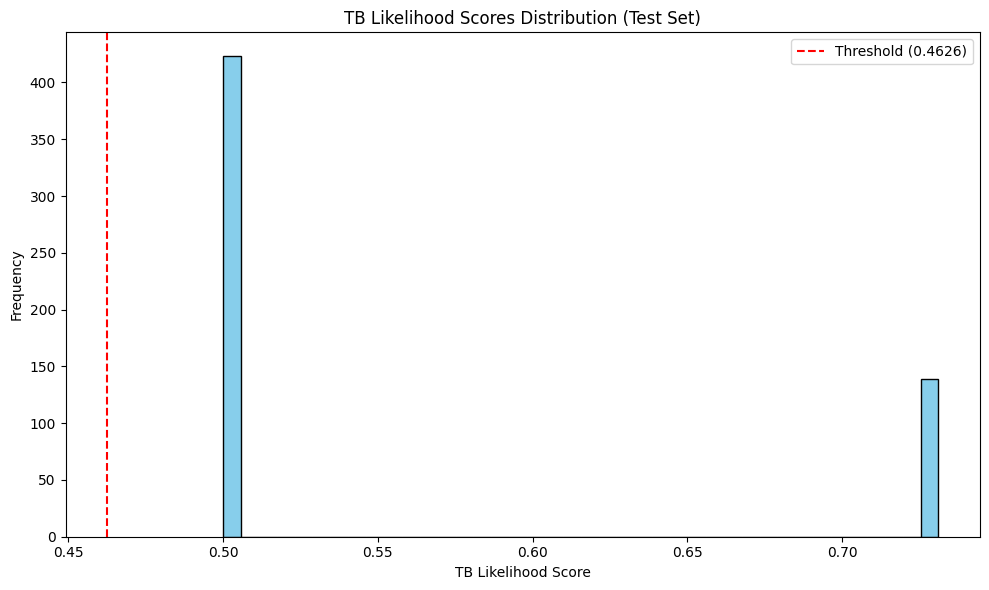

In [64]:

y_pred_prob = torch.sigmoid(torch.tensor(y_pred))  
y_pred_prob = y_pred_prob.flatten().cpu().numpy()
plt.figure(figsize=(10, 6))
plt.hist(y_pred_prob, bins=40, color='skyblue', edgecolor='black')
plt.axvline(x=0.4626, color='red', linestyle='--', label='Threshold (0.4626)')
plt.title('TB Likelihood Scores Distribution (Test Set)')
plt.xlabel('TB Likelihood Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


  0%|          | 0/562 [00:00<?, ?it/s]

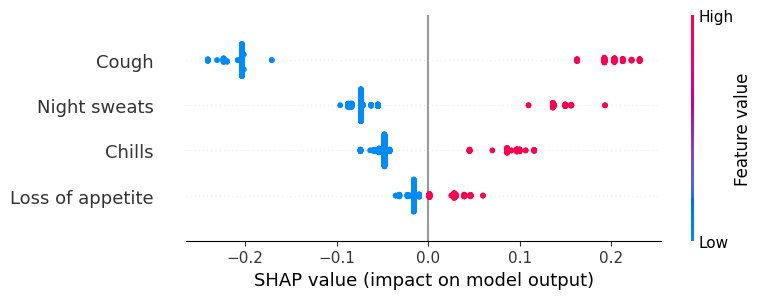

In [66]:
def model_predict(input_data):
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)  
        output = model(input_tensor)
        return torch.sigmoid(output).cpu().numpy()  

explainer = shap.KernelExplainer(model_predict, X_train_tensor.cpu().numpy())  
shap_values = explainer.shap_values(X_test_tensor.cpu().numpy())  
shap.summary_plot(shap_values[0], X_test_merged.values, feature_names=X_test_merged.columns, show=True)
